## Run SimSS simulations and plot the results
Version 0.1
(c) Vincent M. Le Corre (https://github.com/VMLC-PV)

In [1]:
# Package import
import os,platform,warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import loguniform
# Import homemade package by VLC
from SIMsalabim_utils.RunSim import PrepareSimuInputs, DegradationPrepareSimuInputs, RunSimulation # Run simulation
from SIMsalabim_utils.SimSS_plots import PlotJV, PlotJVPerf,PlotNrjDiagSimSS,PlotDensSimSS # Plotting functions
from SIMsalabim_utils.CleanFolder import clean_up_output, clean_file_type # Cleaning functions
from SIMsalabim_utils import plot_settings_screen # Plot settings
 
## General Inputs
warnings.filterwarnings("ignore")           # Don't show warnings
system = platform.system()                  # Operating system
max_jobs = 50#os.cpu_count()-2                 # Max number of parallel simulations (for number of CPU use: os.cpu_count() )
do_multiprocessing = True                      # Use multiprocessing
if system == 'Windows':                     # cannot easily do multiprocessing in Windows
        max_jobs = 1
        do_multiprocessing = False
        try:                                # kill all running jobs to avoid conflicts
            os.system('taskkill.exe /F /IM simss.exe')
        except:
            pass

# Path to SIMsalabim
path2simu = os.path.join(os.getcwd() ,'SIMsalabim','SimSS')


## Define the parameters of the simulation

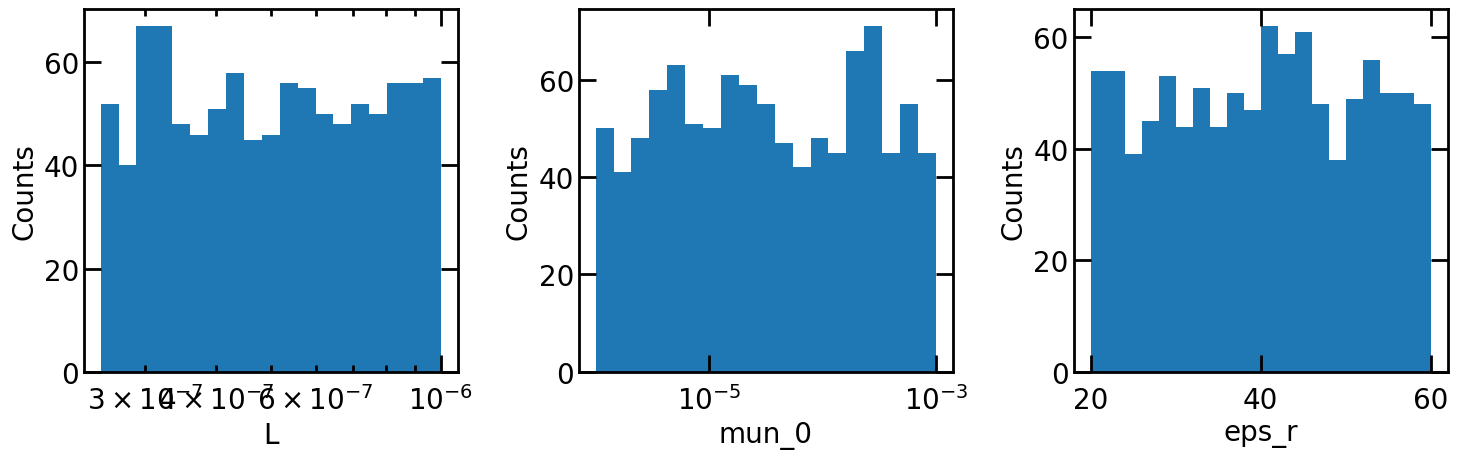

In [2]:
parameters = []
# Define the parameters to vary
parameters.append({'name':'L','lims':[250e-9,1000e-9],'scale':'log'})
parameters.append({'name':'mun_0','lims':[1e-6,1e-3],'scale':'log'})
parameters.append({'name':'eps_r','lims':[20,60],'scale':'linear'})

Np = 1000 # Number of points for the parameter sweep

# add val to parameters that a list of Np points randomly picked between the limits defined above (for each parameter) with the scale defined above
for p in parameters:
    if p['scale'] == 'log':
        p['values'] = list(loguniform.rvs(p['lims'][0],p['lims'][1],size=Np))
    else:
        p['values'] = list(np.random.uniform(p['lims'][0],p['lims'][1],Np))

# Create a subplots for each parameter to check the distribution
fig,ax = plt.subplots(1,len(parameters),figsize=(len(parameters)*5,5))
for i,p in enumerate(parameters):
    if p['scale'] == 'log':
        logbins = np.logspace(np.log10(p['lims'][0],),np.log10(p['lims'][1]),20)
        ax[i].hist(p['values'], bins=logbins)
        ax[i].set_xscale(p['scale'])
    else:
        ax[i].hist(p['values'], bins=20)
        ax[i].set_xscale(p['scale'])

    ax[i].set_xlabel(p['name'])
    ax[i].set_ylabel('Counts')
plt.tight_layout()
plt.show()



In [3]:
# Create a fake experimental JV files  wiht the wanted Vext
Vs = np.geomspace(1e-2,10,10)

Vext = list(-Vs[::-1])
Vext.extend(Vs)
Js = np.geomspace(1e-2,10,10)
Js = list(-Js[::-1])
Js.extend(Js)
df = pd.DataFrame({'Vext':Vext,'Jext':Js})
filename= 'JV_exp.csv'
df.to_csv(os.path.join(path2simu ,filename),index=False, sep=' ')

In [4]:
# Prepare the command strings to run
fixed_str = '-UseExpData 1 -ExpJV '+filename

Simulation_Inputs = DegradationPrepareSimuInputs(path2simu,parameters=parameters,fixed_str=fixed_str,CodeName = 'SimSS',verbose=True) # creates all necessary list inputs

RunSimulation(Simulation_Inputs,max_jobs=max_jobs,do_multiprocessing=do_multiprocessing,verbose=False) # runs the simulations


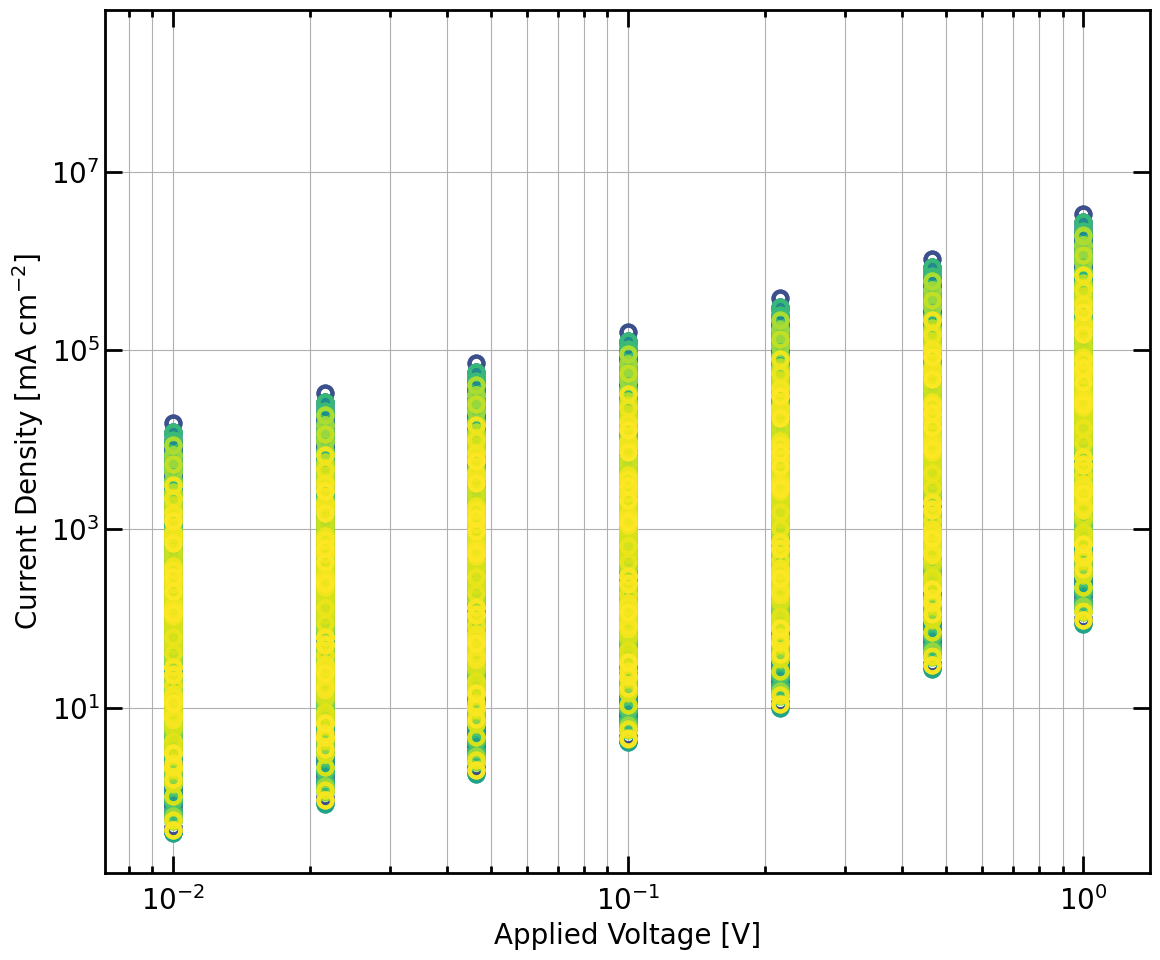

In [5]:
# Make JV plots
str_lst,JV_files,Var_files,scPars_files,code_name_lst,path_lst,labels = Simulation_Inputs
colors = plt.cm.viridis(np.linspace(0,1,max(len(str_lst),3)+1)) # prepare color for plots

PlotJV(JV_files, labels=labels,colors=colors,num_fig=0,plot_type=3,x='Vext',y=['Jext'],legend=False,xlimits=[0,1.4],ylimits=[],x_unit='V',y_unit='mA/cm^2',save_fig=True,fig_name=os.path.join(path2simu,'JV.png'),mark='o',line_type = ['None'],absx=True,absy=True)


In [2]:
# Clean output files from simulation folders
# path2simu = os.path.join('/home/vlc/Desktop' ,'SIMsalabim','SimSS')
Do_Cleaning = True # Careful, this will delete all files in the folder
if Do_Cleaning:
    clean_up_output('tj',path2simu)
    clean_up_output('tVG',path2simu)
    clean_up_output('JV',path2simu)
    clean_up_output('Var',path2simu)
    clean_up_output('scPars',path2simu)
    clean_up_output('log',path2simu)
    clean_up_output('Str4Parallel',path2simu)
    clean_up_output('joblog',path2simu)
    clean_file_type('.jpg',path2simu) # clean all jpg files
    clean_file_type('.png',path2simu) # clean all png files
    